# VGG


In [1]:
!pip install torchinfo

In [2]:
import torch
import torch.nn as nn

In [3]:
cfgs = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [4]:
class VGG(nn.Module):

    def __init__(self, cfg, batch_norm, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = self.make_layers(cfg, batch_norm)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7)) # 7x7 avg poolng (flatten 노드 개수 통일을 위해 adaptive pooling 사용)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def make_layers(self, cfg, batch_norm=False):
        layers = []
        in_channels = 3
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)

In [5]:
from torchinfo import summary

model_vgg16_bn = VGG(cfgs["D"], batch_norm=True)
summary(model_vgg16_bn, input_size=(2,3,224,224), device='cpu')


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [2, 1000]                 --
├─Sequential: 1-1                        [2, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [2, 64, 224, 224]         1,792
│    └─BatchNorm2d: 2-2                  [2, 64, 224, 224]         128
│    └─ReLU: 2-3                         [2, 64, 224, 224]         --
│    └─Conv2d: 2-4                       [2, 64, 224, 224]         36,928
│    └─BatchNorm2d: 2-5                  [2, 64, 224, 224]         128
│    └─ReLU: 2-6                         [2, 64, 224, 224]         --
│    └─MaxPool2d: 2-7                    [2, 64, 112, 112]         --
│    └─Conv2d: 2-8                       [2, 128, 112, 112]        73,856
│    └─BatchNorm2d: 2-9                  [2, 128, 112, 112]        256
│    └─ReLU: 2-10                        [2, 128, 112, 112]        --
│    └─Conv2d: 2-11                      [2, 128, 112, 112]        147,

In [6]:
model_vgg19_bn = VGG(cfgs["E"], batch_norm=True)
summary(model_vgg16_bn, input_size=(2,3,224,224), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [2, 1000]                 --
├─Sequential: 1-1                        [2, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [2, 64, 224, 224]         1,792
│    └─BatchNorm2d: 2-2                  [2, 64, 224, 224]         128
│    └─ReLU: 2-3                         [2, 64, 224, 224]         --
│    └─Conv2d: 2-4                       [2, 64, 224, 224]         36,928
│    └─BatchNorm2d: 2-5                  [2, 64, 224, 224]         128
│    └─ReLU: 2-6                         [2, 64, 224, 224]         --
│    └─MaxPool2d: 2-7                    [2, 64, 112, 112]         --
│    └─Conv2d: 2-8                       [2, 128, 112, 112]        73,856
│    └─BatchNorm2d: 2-9                  [2, 128, 112, 112]        256
│    └─ReLU: 2-10                        [2, 128, 112, 112]        --
│    └─Conv2d: 2-11                      [2, 128, 112, 112]        147,

# 사전 훈련된 모델 활용
- 파이토치 : https://pytorch.org/vision/main/models.html#table-of-all-available-classification-weights
- VGG-16 with ImageNet & BN : https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16_bn.html#torchvision.models.VGG16_BN_Weights

- 데이터 : https://www.microsoft.com/en-US/download/details.aspx?id=54765

In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

In [8]:
# gpu 사용여부 확인

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [9]:
# model = torchvision.models.vgg16_bn(pretrained=True)
model = torchvision.models.vgg16_bn(weights='VGG16_BN_Weights.IMAGENET1K_V1')
model

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


100%|██████████| 528M/528M [00:03<00:00, 158MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [10]:
summary(model, input_size=(2,3,224,224), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [2, 1000]                 --
├─Sequential: 1-1                        [2, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [2, 64, 224, 224]         1,792
│    └─BatchNorm2d: 2-2                  [2, 64, 224, 224]         128
│    └─ReLU: 2-3                         [2, 64, 224, 224]         --
│    └─Conv2d: 2-4                       [2, 64, 224, 224]         36,928
│    └─BatchNorm2d: 2-5                  [2, 64, 224, 224]         128
│    └─ReLU: 2-6                         [2, 64, 224, 224]         --
│    └─MaxPool2d: 2-7                    [2, 64, 112, 112]         --
│    └─Conv2d: 2-8                       [2, 128, 112, 112]        73,856
│    └─BatchNorm2d: 2-9                  [2, 128, 112, 112]        256
│    └─ReLU: 2-10                        [2, 128, 112, 112]        --
│    └─Conv2d: 2-11                      [2, 128, 112, 112]        147,

## 실습

- 데이터 셋 : https://pytorch.org/vision/main/generated/torchvision.datasets.OxfordIIITPet.html


데이터 전처리
- 이미지 변환은 이미지 데이터의 크기를 256으로 키웠다가 224로 중앙 자르기 수행
- 탐지하려는 객체가 중앙에 위치할 확률이 높으므로 불필요한 지역특징을 제거하기 위한 전처리 방법

- 입력 이미지 크기를 224로 바로 리사이즈 할 수도 있지만, 그러면 검출하려는 객체의 크기가 더 작아질 수 있음


일반적으로 **사전학습(pretrained) 모델**을 사용할 때는 ImageNet으로 학습된 모델의 입력 분포에 맞추기 위해 같은 정규화 값(평균, 표준편차)을 사용합니다.

- **사전학습 모델 활용 시**:  
  - ImageNet으로 학습된 모델은 입력 이미지가 이 정규화 값을 기준으로 전처리되었을 때 최적의 성능을 보입니다.
  - 따라서 새로운 데이터셋이 ImageNet과 유사한 분포(자연 이미지 등)를 가진다면 같은 값을 사용하는 것이 좋습니다.

- **새로운 데이터셋이 ImageNet과 많이 다를 경우**:  
  - 만약 데이터셋의 특성이 크게 다르다면(예: 의료 영상, 위성 사진 등)  
  - 새로운 데이터셋 자체의 평균과 표준편차를 계산하여 사용하는 것이 더 적합할 수 있습니다.

In [11]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# gpu 사용여부 확인

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [12]:
from collections import defaultdict

# 라벨 해석 함수 : 0 >> Cat, 1 >> Dog
def label_to_str(label):
    return "Cat" if label == 0 else "Dog"

# 카테고리별로 n개의 샘플 이미지를 수집하여 시각화 하는 함수
def visualize_by_category(dataset, n_samples=5, cmap=None):
    samples = defaultdict(list)
    # 데이터셋을 순화하면서 각 카테고리별로 n_samples 개씩 수집
    for img, label in dataset:
        if len(samples[label]) < n_samples:
            samples[label].append(img)
        # 두 카테고리 모두 n_samples가 모이면 종료
        if len(samples) == 2 and all(len(img) >= n_samples for imgs in samples.values()):
            # "Cat" : [i1, i2, i3, i4, i5], "Dog" : [j1, j2, j3, j4, j5]
            # i, j == image data
            break

    # 수집된 각 카테고리별로 이미지 그리드 생성 및 시각화
    for label, imgs in samples.items():
        # make_grid를 사용하기 전에 각 이미지의 크기가 동일한지 확인합니다.
        grid_img = torchvision.utils.make_grid(imgs, nrow=n_samples, padding=2)
        plt.figure(figsize=(n_samples * 2, 4))
        # (C, H, W) >> (H, W, C)
        plt.imshow(grid_img.permute(1, 2, 0).numpy(), cmap=cmap)
        plt.title(f"Category : {label_to_str(label)}")
        plt.axis("off")
        plt.show()

In [13]:
sap = {"a":123, "B":34234}
for k,v in sap.items():
    print(k,v)
for k in sap:
    print(k, sap[k])

a 123
B 34234
a 123
B 34234


In [14]:
# OxfordIIITPet 데이터셋 로드 (split="trainval" 사용)
dataset = torchvision.datasets.OxfordIIITPet(
    root="data",
    download=True,
    target_types="binary-category",     # 0 : Cat, 1 : Dog
    split="trainval",
    transform=transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
)

100%|██████████| 792M/792M [00:30<00:00, 26.4MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 10.8MB/s]


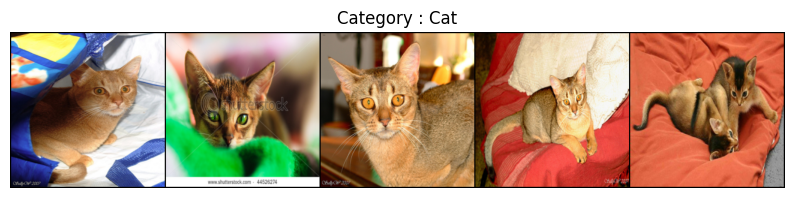

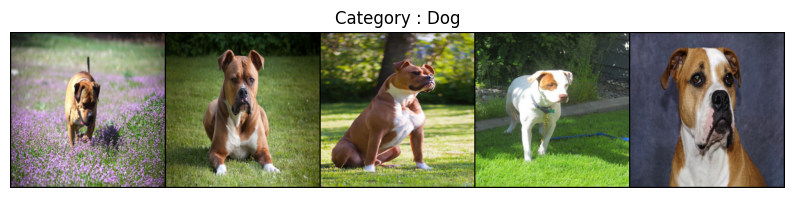

In [15]:
# 카테고리별로 5개의 샘플 이미지 시각화
visualize_by_category(dataset, n_samples=5, cmap=None)

## 모델 활용

In [16]:
import torch, torchvision
import torchvision.transforms as T
from torch.utils.data import random_split, DataLoader

In [17]:
IMG_MEAN = [0.485, 0.456, 0.406]   # ImageNet 통계 [oai_citation:4‡stackoverflow.com](https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2?utm_source=chatgpt.com)
IMG_STD  = [0.229, 0.224, 0.225]

In [18]:
train_tf = T.Compose([
    T.Resize(256),                 # 긴 변 256 유지 후
    T.CenterCrop(224),             # 중앙 224×224 잘라내기
    T.RandomHorizontalFlip(),      # 간단 증강
    T.ToTensor(),
    T.Normalize(IMG_MEAN, IMG_STD)
])
val_tf = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(IMG_MEAN, IMG_STD)
])

In [19]:
full_ds = torchvision.datasets.OxfordIIITPet(
    root='data',
    split='trainval',
    target_types='binary-category',
    download=True,
    transform=train_tf         # 0:Cat 1:Dog  [oai_citation:5‡docs.pytorch.org](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.OxfordIIITPet.html?utm_source=chatgpt.com)
)
train_len = int(len(full_ds)*0.8)
val_len = len(full_ds) - train_len

train_ds, val_ds = random_split(full_ds, [train_len, val_len])
val_ds.dataset.transform = val_tf

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [20]:
import torch.nn as nn
from torchvision.models import vgg16, VGG16_Weights
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)  # 사전학습 가중치 로드 [oai_citation:6‡docs.pytorch.org](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html?utm_source=chatgpt.com)
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:05<00:00, 109MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:
model.classifier[6] = nn.Linear(4096, 2)            # 1000→2 클래스로 교체
model = model.to(device)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [22]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)  # AdamW: decoupled WD [oai_citation:7‡docs.pytorch.org](https://docs.pytorch.org/tutorials/beginner/transfer_learning_tutorial.html?utm_source=chatgpt.com)
sched = torch.optim.lr_scheduler.StepLR(optim, step_size=5, gamma=0.1) # 학습률 스케줄러: 5 epoch마다 lr를 1/10로 감소
                                                                       # → 초반에는 빠르게 학습하고, 일정 단계 이후에는 작은 lr로 미세 조정

In [23]:
train_acc_hist, val_acc_hist = [], []
EPOCHS = 10
for epoch in range(EPOCHS):
    #-----train-----
    model.train()
    corr = tot = 0
    for x,y in tqdm(train_loader, desc=f'E{epoch+1}/{EPOCHS}'):
        x,y = x.to(device), y.to(device)
        optim.zero_grad()
        out = model(x)
        loss = loss_fn(out, y)
        loss.backward()
        optim.step()

        corr += (out.argmax(1)==y).sum().item()
        tot += y.size(0)
    train_acc_hist.append(corr/tot)

    #-----val-----
    model.eval()
    corr = tot = 0
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            corr += (out.argmax(1)==y).sum().item()
            tot += y.size(0)
    val_acc_hist.append(corr/tot)
    print(f'[{epoch+1}] train:{train_acc_hist[-1]:.3f} val:{val_acc_hist[-1]:.33f}')

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


E1/10:   0%|          | 0/92 [00:00<?, ?it/s]

[1] train:0.667 val:0.671195652173913082094713900005445


E2/10:   0%|          | 0/92 [00:00<?, ?it/s]

[2] train:0.735 val:0.826086956521739135261839237500681


E3/10:   0%|          | 0/92 [00:00<?, ?it/s]

[3] train:0.842 val:0.911684782608695676309196187503403


E4/10:   0%|          | 0/92 [00:00<?, ?it/s]

[4] train:0.927 val:0.933423913043478270523678475001361


E5/10:   0%|          | 0/92 [00:00<?, ?it/s]

[5] train:0.941 val:0.944293478260869512119768387492513


E6/10:   0%|          | 0/92 [00:00<?, ?it/s]

[6] train:0.965 val:0.956521739130434811571035425004084


E7/10:   0%|          | 0/92 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d04d4e49a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d04d4e49a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

[7] train:0.963 val:0.964673913043478270523678475001361


E8/10:   0%|          | 0/92 [00:00<?, ?it/s]

[8] train:0.971 val:0.959239130434782594214482287497958


E9/10:   0%|          | 0/92 [00:00<?, ?it/s]

[9] train:0.971 val:0.936141304347826053167125337495236


E10/10:   0%|          | 0/92 [00:00<?, ?it/s]

[10] train:0.964 val:0.945652173913043458952643049997278


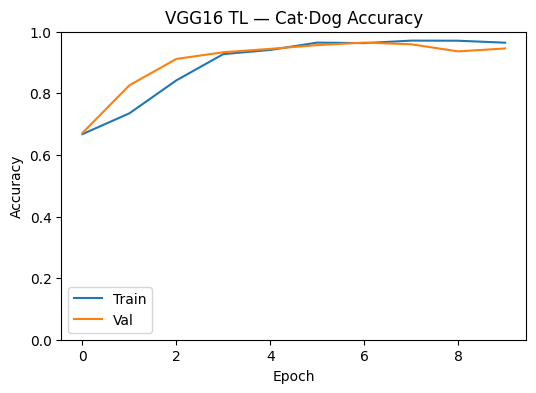

In [25]:
#--- 1) 학습·검증 정확도 그래프 ---
plt.figure(figsize=(6,4))
plt.plot(train_acc_hist, label="Train")
plt.plot(val_acc_hist,   label="Val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.title("VGG16 TL — Cat·Dog Accuracy")
plt.legend()
plt.show()

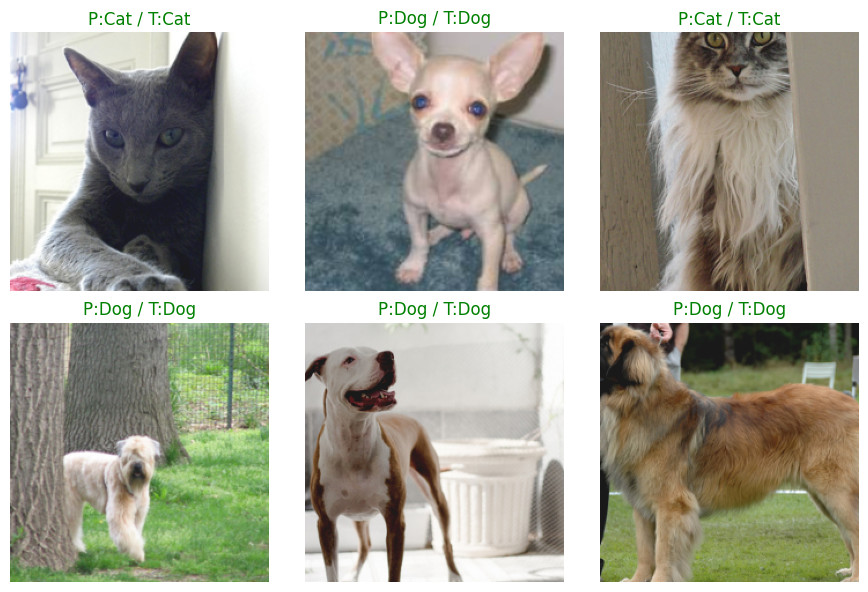

In [26]:
import random
model.eval()
samples = random.sample(range(len(val_ds)), 6)
fig, axes = plt.subplots(2,3, figsize=(9,6))
for ax, idx in zip(axes.flatten(), samples):
    img, label = val_ds[idx]
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device)).argmax(1).item()
    ax.imshow(img.permute(1,2,0).mul(torch.tensor(IMG_STD)).add(torch.tensor(IMG_MEAN)).clamp(0.1))
    ax.set_title(f"P:{'Dog' if pred else 'Cat'} / T:{'Dog' if label else 'Cat'}",
                 color=('g' if pred==label else 'r'))
    ax.axis('off')
plt.tight_layout()
plt.show()